In [36]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import list_datasets
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments
from transformers import Trainer

# Import dataset

In [37]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 162971 datasets currently available on the Hub
The first 10 are: ['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


In [38]:
emotions = load_dataset("dair-ai/emotion", trust_remote_code=True)

# Word Tokenization

In [39]:
model_ckpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [40]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [41]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# Training

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [44]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [45]:
# from huggingface_hub import notebook_login
# notebook_login()

In [46]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

/home/chunghacker/Documents/AI/NLP/Project/Sentiment Classification/venv/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [47]:
# torch.cuda.empty_cache()

In [48]:

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8424, 'grad_norm': 4.5167036056518555, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3170485496520996, 'eval_accuracy': 0.909, 'eval_f1': 0.9085216384728653, 'eval_runtime': 4.5672, 'eval_samples_per_second': 437.906, 'eval_steps_per_second': 7.006, 'epoch': 1.0}
{'loss': 0.2613, 'grad_norm': 4.663308143615723, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2257162481546402, 'eval_accuracy': 0.9265, 'eval_f1': 0.9262728079100228, 'eval_runtime': 4.6721, 'eval_samples_per_second': 428.069, 'eval_steps_per_second': 6.849, 'epoch': 2.0}
{'train_runtime': 276.7822, 'train_samples_per_second': 115.614, 'train_steps_per_second': 1.806, 'train_loss': 0.5518777770996094, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5518777770996094, metrics={'train_runtime': 276.7822, 'train_samples_per_second': 115.614, 'train_steps_per_second': 1.806, 'total_flos': 720342861696000.0, 'train_loss': 0.5518777770996094, 'epoch': 2.0})

In [49]:
preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis=1)

  0%|          | 0/32 [00:00<?, ?it/s]

In [50]:

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [51]:
y_valid= emotions['validation']['label']
labels = emotions['train'].features['label'].names

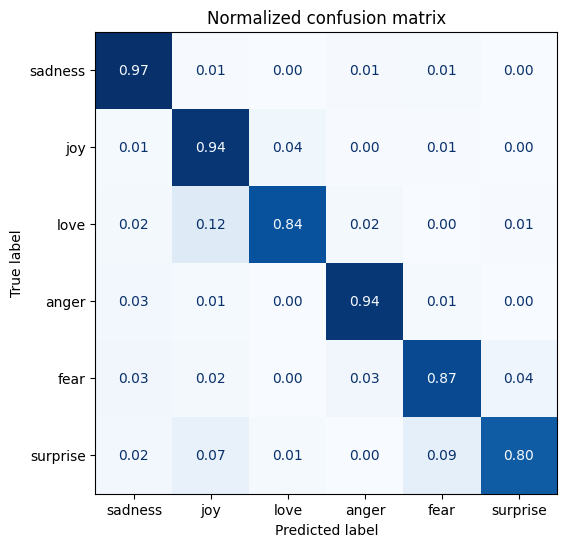

In [52]:
plot_confusion_matrix(y_preds, y_valid, labels)